## Kyle EDA w/ cleaned data 

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
!pip install yfinance
import yfinance as yahooFinance
import matplotlib.ticker as mtick

In [ ]:
ts_data = pd.read_csv('../congress-stock-trades-dsir523/data/complete_daily2_cumulative.csv')

ts_data.rename(columns = {'Unnamed: 0': 'tx-dates'}, inplace = True)

ts_data.set_index('tx-dates', drop = True, inplace = True)

ts_data.index = pd.to_datetime(ts_data.index)

trunc_ts = ts_data[1825:]

weekly_2014_pct = ts_data['percent_change'].resample('W').mean()
weekly_2014_cum = ts_data['portfolio_delta'].resample('W').mean()

weekly_2019_pct = trunc_ts['percent_change'].resample('W').mean() + 0.1167415930249301  # rebasing to 0
weekly_2019_cum = trunc_ts['portfolio_delta'].resample('W').mean()

In [ ]:
#Pulling SPX data using yFinance
SPX_data = yahooFinance.Ticker("^GSPC")

SPX_df = SPX_data.history(period="10y")

SPX_close = SPX_df['Close']
trunc_SPX_close = SPX_close[360:]


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13, 6))


fig.suptitle("Comparing Congress Avg Performance to S&P", fontsize = 18)
fig.supxlabel('Time')

ax1.plot(weekly_2019_pct)
ax1.set_ylabel('Total ($)');

ax2.plot(trunc_SPX_close.diff().dropna())
#ax2.axhline(nancy_aapl_ts['AAPL']['volume'].median()).set(color = 'red')
#plt.setp(ax2.get_xticklabels(), visible = True) # ??? How to get working ???
#ax.xaxis.set_tick_params(labelbottom=True)

fig.tight_layout()

In [ ]:
#Train-test-split
split = int(round(weekly_2019_pct.shape[0] * 0.8, 0))
train = weekly_2019_pct.iloc[0:split]
test = weekly_2019_pct.iloc[split:]

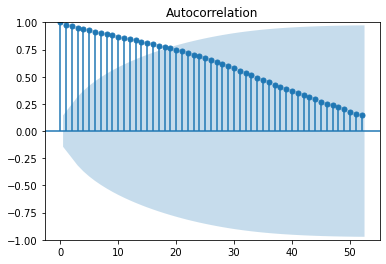

In [ ]:
plot_acf(weekly_2019_cum, lags =52);

/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


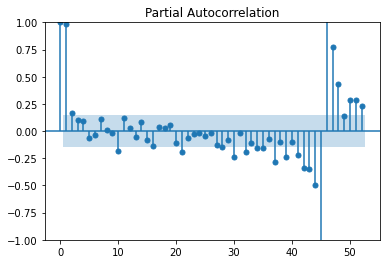

In [ ]:
plot_pacf(weekly_2019_cum, lags = 52);

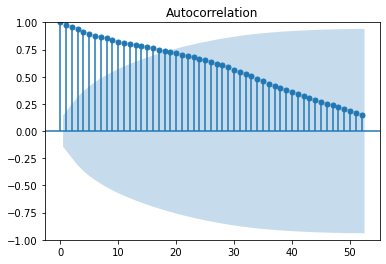

In [ ]:
plot_acf(weekly_2019_pct, lags = 52);

/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


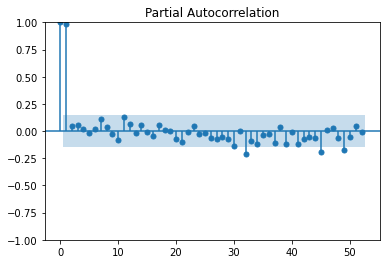

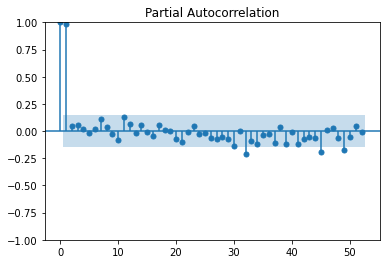

In [ ]:
plot_pacf(weekly_2019_pct, lags = 52)

In [ ]:
print(f'Test Statistic: {adfuller(weekly_2019_pct)[0]}, p-value: {adfuller(weekly_2019_pct)[1]}')

Test Statistic: -1.7758723357586081, p-value: 0.3925044784076301


In [ ]:
weekly_diff = weekly_2019_cum.diff().dropna()

In [ ]:
print(f'Test Statistic: {adfuller(weekly_diff)[0]}, p-value: {adfuller(weekly_diff)[1]}')

Test Statistic: -11.456066280288074, p-value: 5.702813821773804e-21


Stationarity achieved

In [ ]:
def plot_all(data_list): #Data_list in format: [train, test, train_preds, test_preds]
    count = 1
    label_dict = {1:'train', 2:'test', 3: 'train_preds', 4: 'test_preds'}
    fig, ax = plt.subplots(figsize = (10,7))
    for obj in data_list:
        ax.plot(obj, label = label_dict[count])
        count += 1
    ax.set_xlabel('Time')
    ax.set_ylabel('% change')
    ax.set_title('Plot of Model Performance')
    ax.legend(loc = 'upper left')
    
def evaluate_arima(df, p, d, q, diff):
    
    #Train-test-split
    split = int(round(df.shape[0] * 0.8, 0))
    train = df.iloc[0:split]
    test = df.iloc[split:]

    
    ar = ARIMA(endog = train,
            order = (p, d, q))

    model = ar.fit()

    train_preds = model.predict(0, split)
    test_preds = model.predict(split, 184)

    print(mean_squared_error(test, test_preds))
    if diff:
        plot_all([train.diff().dropna(), test.diff().dropna(), train_preds.diff().dropna(), test_preds.diff().dropna()])
    else:
        plot_all([train, test, train_preds, test_preds])

/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1092081789303923.6


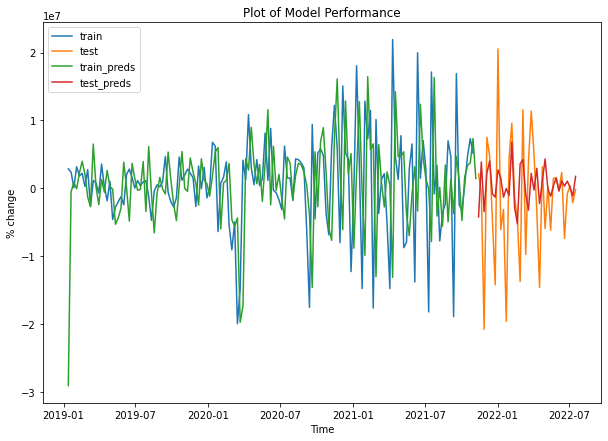

In [ ]:

evaluate_arima(weekly_2019_cum, 30, 1, 4, True)

/Users/kyleness/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1092081789303923.6


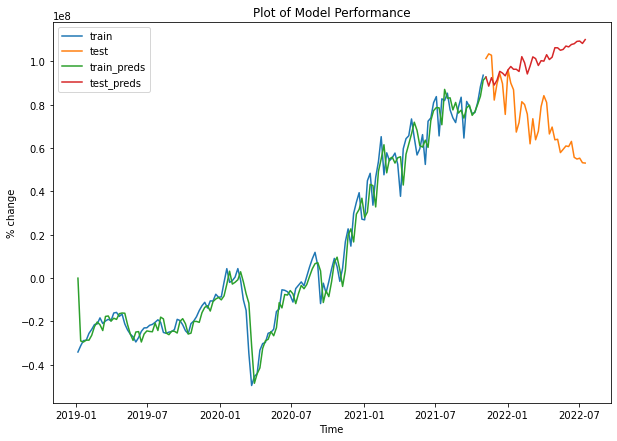

In [ ]:
evaluate_arima(weekly_2019_cum, 30, 1, 4, False)

----------- Did not have time to run ----------

In [ ]:
#train test split 

split = int(round(weekly_2019_cum.shape[0] * 0.8, 0))
train = weekly_2019_cum.iloc[0:split]
test = weekly_2019_cum.iloc[split:]

s1 = SARIMAX(endog = train,
             order = (2, 1, 2),
             seasonal_order = (1, 1, 1, 52))

sarima_model = s1.fit(disp=0)

#Generate predictions on train, test data
train_preds = sarima_model.predict(0, split)
test_preds = sarima_model.predict(split, 142)

# Evaluate predictions.
print(mean_squared_error(test['Weekly_Sales'], test_preds))

plot_all([train, test, train_preds, test_preds])


KeyboardInterrupt: 